# Transfer learning task on delta pCO2

## Formula
delta pCO2 =  pCO2ocean - pCO2atm 

where pCO2atm = xCO2 (umol/mol) * pATM (atm)   (pATM = atmospheric pressure)


In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-03-28 09:06:06.973482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [49]:
tf.keras.backend.clear_session()

In [45]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1)

In [3]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images(dir_name)
data_socat, pco2_socat = preprocess_images(dir_name, socat = True)

val_data,val_pco2 = preprocess_images(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images(val_dir_name,"035",socat=True)

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2t = read_xarray(dir_name)

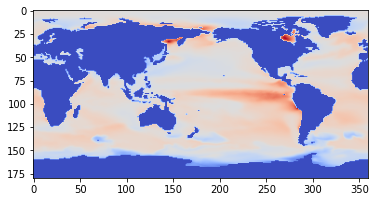

In [44]:
# delta pco2 calculation

pco2_atm = np.array(xco2.XCO2)[:,None,None]*patm.pATM.data
dpco2 = preprocess_image_reduced(pco2t.pCO2.data - pco2_atm)

plt.imshow(np.flipud(dpco2[0]),cmap="coolwarm")

In [47]:
INPUT_SHAPE=data_socat[0].shape
OUTPUT_SHAPE=pco2_socat[0].shape

from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPool2D , Flatten, Input

base_model = tf.keras.models.load_model('../../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})


for layer in base_model.layers[:-4]:
    layer.trainable = False

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [50]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-4),
)

model_path="../../models/dpco2_transfer_CNN.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 64

history = base_model.fit(
    data,
    dpco2,
    batch_size=batch_size,
    epochs=epochs,
    workers=-1,
    validation_data=(data, dpco2),
    callbacks=callbacks,
)

Epoch 1/50
7/7 [==============================] - 20s 2s/step - loss: 58.0227 - val_loss: 52.5661
Epoch 2/50
7/7 [==============================] - 7s 973ms/step - loss: 55.4969 - val_loss: 52.9597
Epoch 3/50
7/7 [==============================] - 7s 975ms/step - loss: 57.1119 - val_loss: 52.1948
Epoch 4/50
7/7 [==============================] - 7s 976ms/step - loss: 55.2621 - val_loss: 51.4712
Epoch 5/50
7/7 [==============================] - 7s 976ms/step - loss: 54.3308 - val_loss: 49.8472
Epoch 6/50
7/7 [==============================] - 7s 975ms/step - loss: 53.7180 - val_loss: 49.0973
Epoch 7/50
7/7 [==============================] - 7s 980ms/step - loss: 50.8795 - val_loss: 48.5223
Epoch 8/50
7/7 [==============================] - 7s 974ms/step - loss: 53.4679 - val_loss: 47.0847
Epoch 9/50
7/7 [==============================] - 7s 975ms/step - loss: 50.8613 - val_loss: 46.9035
Epoch 10/50
7/7 [==============================] - 7s 974ms/step - loss: 50.3351 - val_loss: 46.0210
E

In [51]:
best_model = tf.keras.models.load_model('../../models/dpco2_transfer_CNN.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_frames=best_model.predict(data,verbose=1)
predicted_frames[dpco2==0]=0.0

14/14 [==============================] - 2s 111ms/step


In [53]:
def inverse_scale_image(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    y_true=np.nan_to_num(df)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [80]:
dpco2_tmp=pco2t.pCO2.data - pco2_atm
y_true,y_pred = inverse_scale_image(predicted_frames,dpco2_tmp)  

print("Full RMSE score:")
np.sqrt(custom_rmse(y_pred,y_true))

Full RMSE score:


15.09981453316252

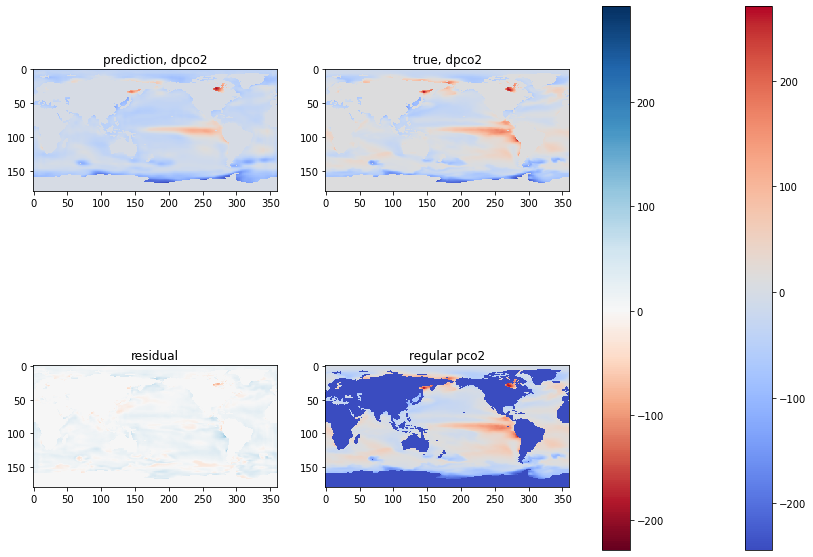

In [59]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, dpco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, dpco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("regular pco2")

#plt.savefig('../../assets/transfer_nfp.png')

plt.show()

In [77]:
rmses = []

for i in range(421):    
    rmse = np.sqrt(custom_rmse(y_pred[i],y_true[i]).numpy())
    rmses.append(rmse)

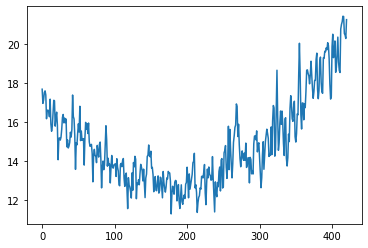

In [78]:
plt.plot(rmses)

(array([2.0000000e+00, 0.0000000e+00, 2.0000000e+00, 6.0000000e+00,
        7.0000000e+00, 1.9000000e+01, 2.1000000e+01, 3.9000000e+01,
        7.7000000e+01, 1.3300000e+02, 2.7600000e+02, 4.3000000e+02,
        8.8400000e+02, 1.8470000e+03, 4.3920000e+03, 1.1876000e+04,
        3.6103000e+04, 1.1539900e+05, 3.4444200e+05, 9.6538800e+05,
        2.5243500e+06, 1.4706842e+07, 5.0017650e+06, 2.5736620e+06,
        7.3735100e+05, 1.7180000e+05, 4.9426000e+04, 1.8142000e+04,
        8.1170000e+03, 3.7930000e+03, 1.9510000e+03, 1.0030000e+03,
        5.2200000e+02, 3.1000000e+02, 1.5900000e+02, 9.5000000e+01,
        6.7000000e+01, 3.7000000e+01, 3.4000000e+01, 1.3000000e+01,
        5.0000000e+00, 5.0000000e+00, 0.0000000e+00, 2.0000000e+00,
        4.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([-228.57841966, -218.17326332, -207.76810698, -197.36295064,
        -186.95779431, -176.55263797, -166.14748163, -155.74232529,
        

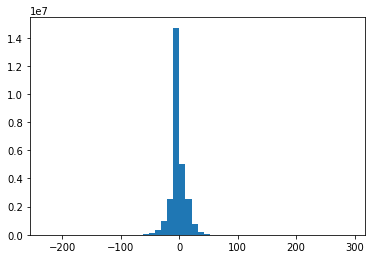

In [70]:
plt.hist(np.array(y_true-y_pred).flatten(),bins=50)

In [85]:
filenames = []

d = y_true - y_pred
norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

for i in range(421):
    figure, axis = plt.subplots(2, 2,figsize=(12, 6))
    # plot the line chart
    img=axis[0][0].imshow(np.flipud(y_pred[i]),cmap="coolwarm", interpolation="nearest")
    axis[0][0].set_title("prediction, dpco2")
    plt.colorbar(img,ax=axis)

    img1=axis[0][1].imshow(np.flipud(y_true[i]),cmap="coolwarm", interpolation="nearest")
    axis[0][1].set_title("true, dpco2")

    diff=np.flipud(np.squeeze(y_true[0]-y_pred[i]))
    img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
    axis[1][0].set_title("residual")
    plt.colorbar(img2,ax=axis)


    img2=axis[1][1].imshow(np.flipud(pco2[i]),cmap="coolwarm", interpolation="nearest")
    axis[1][1].set_title("regular pco2")
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
    

In [86]:
import imageio
import matplotlib.colors as mcolors
# build gif
with imageio.get_writer('../../assets/dpco2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)